In [2]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

from pprint import pprint
import numpy as np
import torchinfo
from matplotlib import pyplot as plt
import time
import cv2
from PIL import Image
import time
from tqdm import tqdm
import torchinfo 
from pprint import pprint

# this is same for all the code

# Dataset class implementation was done by Anshul EE20BTECH11052
# Residual block and various functions like mse, mae, ssim were written by Dhruv Srikanth EE20BTECH11041
# Basic architecture of the model was written by Utkarsh Doshi E20BTECH11052

In [2]:
channels_img = 3
batch_size = 128
data_dir = r'C:/Users/utkar/Desktop/ivp/FFHQ64x64/'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((64, 64)),
    #transforms.Normalize(())
    ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

device = 'cuda' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!nvidia-smi

Sat Apr 29 23:27:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.52       Driver Version: 528.52       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0    24W /  95W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

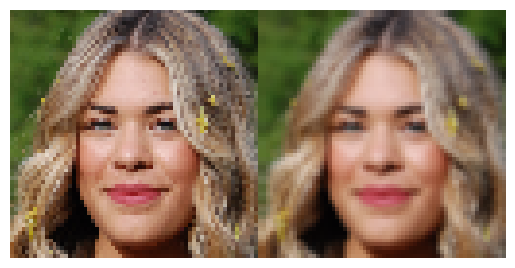

In [4]:
img = dataset[10500][0].permute(1, 2, 0)

img_blur = cv2.blur(np.array(img), (2, 2))

imgs = np.concatenate((img, img_blur), 1)
plt.axis('off')
plt.imshow(imgs)
plt.show()



# idea and code modified by Anshul Gupta

In [5]:


class SSConv(nn.Module):   # spatially separable convolution
    def __init__(self, in_c, out_c):
        super(SSConv, self).__init__()
        self.ResBlock = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=(1, 3), padding=(0, 1), bias=False),
            nn.ReLU(True),
            nn.Conv2d(out_c, out_c, kernel_size=(3, 1), padding=(1, 0), bias=False),     
            nn.ReLU(True)
        )

    def forward(self, x, res=True):
        return self.ResBlock(x)


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResidualBlock, self).__init__()
        
        self.conv1_a = SSConv(in_c, out_c)
        self.conv1_b = SSConv(out_c, out_c)
        self.relu1 = nn.ReLU()
        
        self.conv2_a = SSConv(out_c, out_c)
        self.conv2_b = SSConv(out_c, out_c)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        res = x
        x = self.conv1_a(x)
        x = self.conv1_b(x)
        x = self.relu1(x)
        x = self.conv2_a(x)
        x = self.conv2_b(x)
        x = self.relu2(x)
        return x + res


In [7]:
class ResVit(nn.Module):
    def __init__(self, input_shape, hidden_size, num_heads, num_layers):
        super(ResVit, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], hidden_size, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv1_out_size = (input_shape[1] + 2*1 - 3) // 1 + 1
        self.pos_encoder = nn.Parameter(torch.zeros(1, self.conv1_out_size**2, hidden_size))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads), num_layers=num_layers)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        batch_size, _, height, width = x.size()
        x = x.flatten(2).transpose(1, 2)   # Flatten and transpose output
        pos_encoding = self.pos_encoder.repeat(batch_size, 1, 1)
        x = x + pos_encoding
        x = self.transformer(x)
        x = x.transpose(1, 2)
        x = x.reshape(batch_size, -1, self.conv1.out_channels, self.conv1_out_size, self.conv1_out_size) # Transpose and unflatten output
        x = x.view(batch_size, -1, self.conv1.out_channels, self.conv1_out_size, self.conv1_out_size)
        x = self.relu2(x)
        x = x.squeeze(1)
        x = self.conv2(x)
        return x


# resvit = ResVit((256, 32, 32), 256, 4, 2)
# print(resvit)
# x = torch.randn((1, 256, 32, 32))
# y = resvit(x)
# print(y.shape)


In [8]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta
        
        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)  # weight initializing
        
    def forward(self, latents):
        latents = latents.permute(0, 2, 3, 1).contiguous()  # taking dimension (channel) to right end
        latents_shape = latents.shape
        flat_latents = latents.view(-1, self.D)
        
        # computing L2 distance
        dist = torch.sum(flat_latents ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(flat_latents, self.embedding.weight.t())  # [BHW x K]
            
        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [BHW, 1]
        
        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [BHW x K]

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [BHW, D]
        quantized_latents = quantized_latents.view(latents_shape)  # [B x H x W x D]
        
        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())
        
        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents.permute(0, 3, 1, 2).contiguous(), vq_loss  # [B x D x H x W]

In [9]:
# VQ-VAE
class VQVAE(nn.Module):
    def __init__(self,
                 in_c,
                 embedding_dim,
                 num_embeddings,
                 hidden_dims=None,
                 beta=0.25,
                 img_size=64,
                 ):
        super(VQVAE, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_embedding = num_embeddings
        self.img_size = img_size
        self.beta = beta
        
        modules = []
        if hidden_dims is None:
            hidden_dims = [128, 256]
        
        for h_dim in hidden_dims:
            modules.append(nn.Sequential(
                nn.Conv2d(in_c, out_channels=h_dim, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(True),
            ))
            in_c = h_dim
            
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            )
        )
        
        for _ in range(1):
            modules.append(
                ResidualBlock(in_c, in_c)
                #ResVit((256, 16, 16), 256, 4, 1)
            )   # see for relu   
            # if _ % 2 == 0:
            #     modules.append(
            #         #ResidualBlock(in_c, in_c)
            #         ResVit((256, 32, 32), 256, 4, 1, True)
            #     )   # see for relu
            # else:
            #     modules.append(
            #         ResidualBlock(in_c, in_c)
            #         #ResVit((256, 32, 32), 256, 4, 1, True)
            #     )   # see for relu
                
        modules.append(nn.LeakyReLU())
        
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, embedding_dim, kernel_size=1, stride=1),
                nn.LeakyReLU()
            )
        )
        
        self.encoder = nn.Sequential(*modules)
        
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, self.beta)
        
        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim, hidden_dims[-1], kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            )
        )
        
        
        for _ in range(1):
            modules.append(
                ResidualBlock(in_c, in_c)
                #ResVit((256, 16, 16), 256, 4, 1)
            )   # see for relu                          
            #if _ % 2 == 0:
            #    modules.append(
            #        #ResidualBlock(in_c, in_c)
            #        ResVit((256, 32, 32), 256, 4, 1, True)
            #    )   # see for relu                          
            #else:
            #    modules.append(
            #        ResidualBlock(in_c, in_c)
            #        #ResVit((256, 32, 32), 256, 4, 1, True)
            #    )   # see for relu
            
        modules.append(nn.LeakyReLU())
        hidden_dims.reverse()
        
        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU()
                )
            )
            
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1], out_channels=3, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
            )
        )
        
        self.decoder = nn.Sequential(*modules)
         
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, z):
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        encodings = self.encoder(x)
        #print(encodings.shape)
        quantized_vec, vq_loss = self.vq_layer(encodings)
        return [self.decoder(quantized_vec), x, vq_loss]
    
    def loss_f(self, *args, **kwargs):
        recons = args[0]
        inputs = args[1]
        vq_loss = args[2]
        
        recons_loss = F.mse_loss(recons, inputs)
        
        loss = recons_loss + vq_loss
        return loss, recons_loss, vq_loss
    
    def sample(self, num_samples, current_device):
        raise Warning('VQVAE sampler is not implemented.')

    def generate(self, x):
        return self.forward(x)[0]


In [10]:
# in_c, embedding_dim, num_embeddings, hidden_dims, beta=0.25, img_size=64,
vqvae = VQVAE(3, 128, 512).to(device)

In [11]:
# x = torch.rand((1, 3, 128, 128)).to('cuda')
# print(x.shape)
# encode_vec = vqvae.encoder(x)
# vqvae.vq_layer(encode_vec)[0].shape

In [12]:
pprint(torchinfo.summary(vqvae, (5, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [5, 3, 64, 64]            --
├─Sequential: 1-1                        [5, 128, 16, 16]          --
│    └─Sequential: 2-1                   [5, 128, 32, 32]          --
│    │    └─Conv2d: 3-1                  [5, 128, 32, 32]          6,272
│    │    └─LeakyReLU: 3-2               [5, 128, 32, 32]          --
│    └─Sequential: 2-2                   [5, 256, 16, 16]          --
│    │    └─Conv2d: 3-3                  [5, 256, 16, 16]          524,544
│    │    └─LeakyReLU: 3-4               [5, 256, 16, 16]          --
│    └─Sequential: 2-3                   [5, 256, 16, 16]          --
│    │    └─Conv2d: 3-5                  [5, 256, 16, 16]          590,080
│    │    └─LeakyReLU: 3-6               [5, 256, 16, 16]          --
│    └─ResidualBlock: 2-4                [5, 256, 16, 16]          --
│    │    └─SSConv: 3-7                  [5, 256, 16, 16]          393,2

(tensor(0.0092), tensor(0.0695))


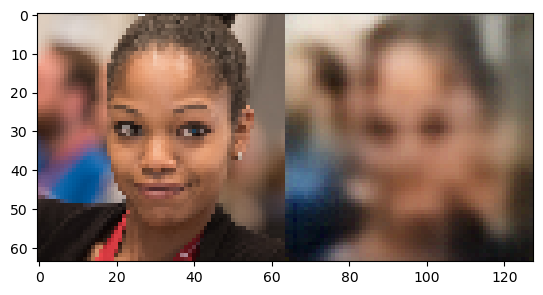

In [13]:
num_training_updates = 15000

# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2
# 

# embedding_dim = 64
# num_embeddings = 512
# commitment_cost = 0.25
decay = 0.99

learning_rate = 1e-4
optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


p = r"C:\Users\utkar\Desktop\ivp\models tried\day-5\vqvae_day5_epoch5.pt"
vqvae = torch.load(p)


from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

def mse(img1, img2):
    target = img1
    preds = img2
    mean_squared_error = MeanSquaredError()
    mean_s = mean_squared_error(preds, target)
    mean_absolute_error = MeanAbsoluteError()
    mean_abs = mean_absolute_error(preds, target)
    return mean_s, mean_abs
    
def display_func():
    with torch.no_grad():
        n = 10001
        img = torch.unsqueeze(train_loader.dataset[n][0], 0).to('cuda')
        out = vqvae(img)[0]
        
        print(mse(img.cpu(), out.cpu()))
        pic = np.transpose(np.concatenate((img.cpu(), out.cpu()), 3)[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()

display_func()

In [ ]:
from tqdm import tqdm

def train_vqvae(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    
    train_loss = []
    recon_loss = []
    vq_loss = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_vq_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)

            optimizer.zero_grad()

            outputs = model(data)
            loss, recon_loss_batch, vq_loss_batch = model.loss_f(*outputs)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_recon_loss += recon_loss_batch.item()
            epoch_vq_loss += vq_loss_batch.item()

            progress_bar.set_postfix({
                "Train Loss": epoch_train_loss / (batch_idx + 1),
                "Recon Loss": epoch_recon_loss / (batch_idx + 1),
                "VQ Loss": epoch_vq_loss / (batch_idx + 1),
            })
            
        train_loss.append(epoch_train_loss / len(train_loader))
        recon_loss.append(epoch_recon_loss / len(train_loader))
        vq_loss.append(epoch_vq_loss / len(train_loader))
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Recon Loss: {recon_loss[-1]:.4f}, VQ Loss: {vq_loss[-1]:.4f}")
        display_func()
        if epoch % 5 == 0:
            PATH = r'C:/Users/utkar/Desktop/ivp/models tried/day-5/vqvae_day5_epoch' + str(epoch) + '.pt'
            torch.save(vqvae, PATH)
    return train_loss, recon_loss, vq_loss


In [ ]:
train_vqvae(vqvae, train_loader, optimizer, criterion, device, epochs=20)

In [ ]:
# PATH = r'C:/Users/utkar/Desktop/ivp/models tried/day-5/vqvae_day5-epoch2.pt'
# torch.save(vqvae, PATH)

In [ ]:
display_func()

In [ ]:
def display_func():
    with torch.no_grad():
        n = np.random.randint(0, 50000)
        print(n)
        img = torch.unsqueeze(train_loader.dataset[n][0], 0).to('cuda')
        out = vqvae(img)[0]
        pic = np.transpose(np.concatenate((img.cpu(), out.cpu()), 3)[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()
        
display_func()

In [ ]:
codebook_embeddings = vqvae.vq_layer.embedding
codebook_embeddings.weight[45]

In [ ]:
dir(vqvae.vq_layer.embedding.state_dict)